# Typeracer dataset report

The dataset was datamined on 2022/11/16 from https://play.typeracer.com/

Typeracer is an online typing game, where multiple players are given a text and the task is to (correctly) type it as fast as possible. 
Overall goal of this game is to improve ones typing skills - speed and accuracy.

Data collected was limited to english texts, so that analysis can done on the QWERTY keyboard.


Each row of the dataset represents one match played by one player.
The dataset consists of 8543 rows and 12 columns:
- player:  name of the player
- match: n-th match the player has ever played 
- wpm: words per minute, a measure of typing speed
- pos: at which position the player has placed (first=won, second, etc.)
- acc: percentage of letters that were correctly written on the first try
- letters: letters the text consisted of
- latencies: time delay before each letter was correctly typed
- mistakes: mistakes signifies whether letter was written correctly at the first try or not
- letters_all: all letters typed and deleted (includes mistakes)
- latencies_all: time delay before all keypresses
- operations: operations[i] signifies whether letters_all[i] was: correctly typed, typed a mistake, deleted a mistake, deleted a correct letter
- durations: how long each keypress lasted (keyboard buttons continuously send signal when pressed down)


(does not consider the existence of the shift key)
shift-key information is unfortunately not included

Between 10%-20% of all replays were thrown out to keep the data clean
- some parts of the typeracer replay have bugs (eg. characters get swapped, but the app somehow pretends it didn't happened)
- some rarer parts of the replay encoding evade my understanding
- even though the text may be in english, a few players use non-english layouts and can mistakenly write a non-asci char; this would make it hard to say what key was pressed
- detecting the keyboard layout is nearly imposible, unless the player specifies what layout they are using; in a case that the layout is not QWERTY (eg. AZERTY, dvorak, etc.) no replay is collected for that player

There are no missing values.
Match text (the column 'letters') is duplicated for each player in the match.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import keyboard
import scraper
import parse_log
import time

df:pd.DataFrame = scraper.load_mined()
df[['wpm','match','pos']] = df[['wpm','match','pos']].astype('int32')
df[['player']] = df[['player']].astype('string')
plt.rcParams["figure.figsize"] = (20,10)
def safe_get(df,item):
    return df.loc[item][0] if (item != None) and (item in df.index) else 0
def safe_get_row(df,item):
    return df.loc[item] if item in df.index else 0

def count_occurances(arrs):
    ret = defaultdict(lambda:0)
    for i,arr in arrs.items():
        for item in arr:
            ret[item] += 1
    return ret

def count_latencies(latencies,letters):
    ret = defaultdict(lambda:0)
    for (_,lat_arr),(_,let_arr) in zip(latencies.items(),letters.items()):
        for i,item in enumerate(let_arr):
            ret[item] += lat_arr[i]
    return ret


## Column types

In [2]:

print(df.dtypes)

player            string
match              int32
wpm                int32
acc              float64
pos                int32
letters           object
latencies         object
mistakes          object
letters_all       object
latencies_all     object
durations         object
operations        object
dtype: object


- letters, letters_all are ndarrays of char
- durations, latencies, latencies_all, durations are ndarrays of int
- mistakes is an ndarray of bool
- operations is an ndarray of values 0-3, categorical






In [3]:
print(df.describe())

               match          wpm          acc          pos
count    8543.000000  8543.000000  8543.000000  8543.000000
mean    15691.801007    79.625658    96.698069     2.364158
std     73769.434460    28.010164     1.827650     1.221256
min         1.000000    10.000000    85.700000     1.000000
25%       188.000000    61.000000    95.700000     1.000000
50%       936.000000    78.000000    96.900000     2.000000
75%      4537.500000    95.000000    98.000000     3.000000
max    630574.000000   244.000000   100.000000     7.000000


### Hypotheses
- mistakes cost a lot of time since they require deleting and retyping => lots of keypresses; so there should be clear correlation between WPM and accuracy
- the further away a letter is from the neutral hand position the bigger the latency as there is more movement required
- more frequently used buttons probably have strongly developed muscle memory compared to seldomly used buttons
- letters that require using shift to type have larger latency (as total of 2 keypresses are required) and better accuracy (less speed related mistakes; oftentimes as the first letter at the start of a sentence)
- frequently switching hands while might have bad repercussions on accuracy due to synchronisation problems
- not swithing hands frequently enough might lead to lower speed, because figers can't 'prepare' to type the next letter and are required to perform lots of (possibly unconfortable) motions without rest
- thumbs and pinkies are less nimble than other fingers, which probably leads to longer press duration  
- in longer texts, the player gets progressively more and more tired, so it is expected that wpm and accuracy go down while latency goes up
- all those shortcoming might get lessened with experience
- high WPM players are more likely to win

In [4]:
df['latencies'] = df['latencies'].apply(lambda arr:arr[1:])
df['mistake_letters'] = df.apply(lambda row: row['letters'][row['mistakes']], axis=1)
df['mistake_latencies'] = df.apply(lambda row: row['latencies'][row['mistakes']], axis=1)

## Player consistency

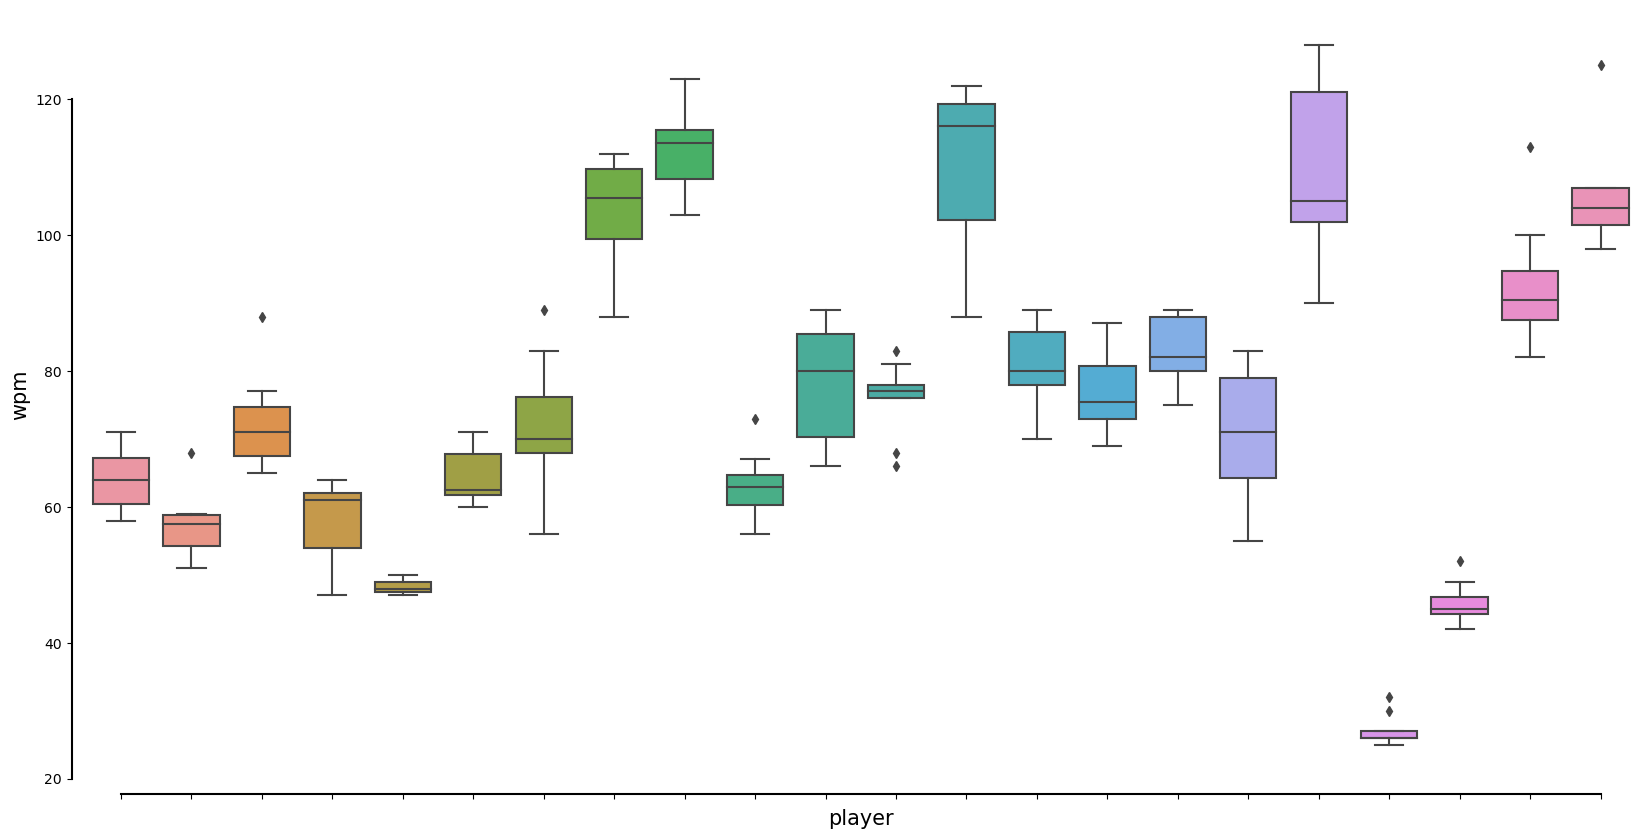

In [5]:
pl = sb.boxplot(x="player", y="wpm",data=df.head(200))
pl.set(xticklabels=[])
sb.despine(offset=10, trim=True)

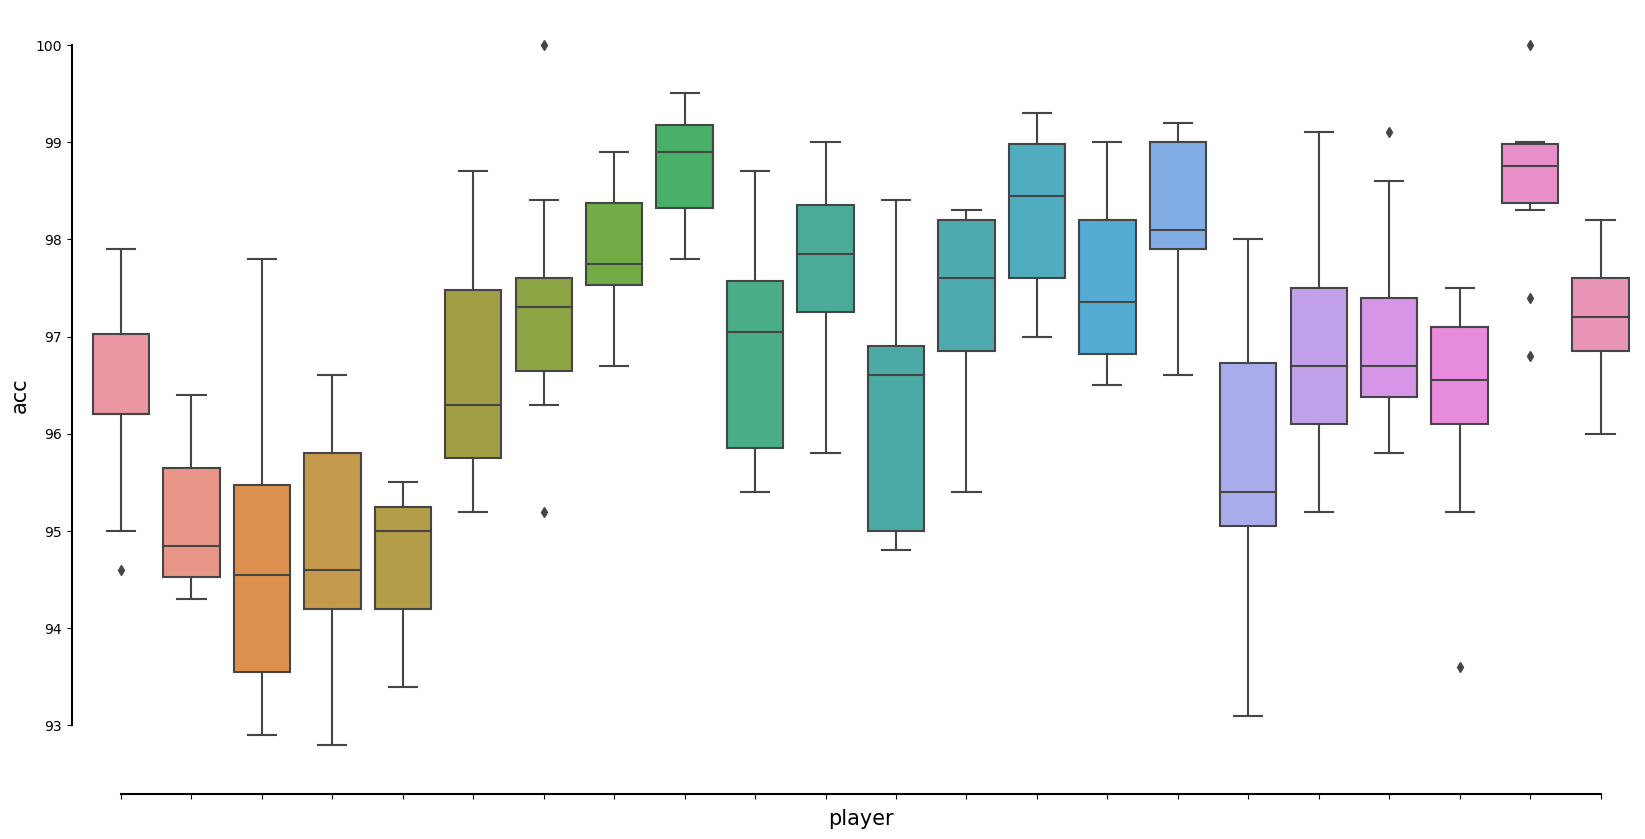

In [6]:
pl = sb.boxplot(x="player", y="acc",data=df.head(200))
pl.set(xticklabels=[])
sb.despine(offset=10, trim=True)

Some players seem to be more consistent than others. This applies to both wpm and accuracy.

## Keyboard analytics

Rates of using a key:

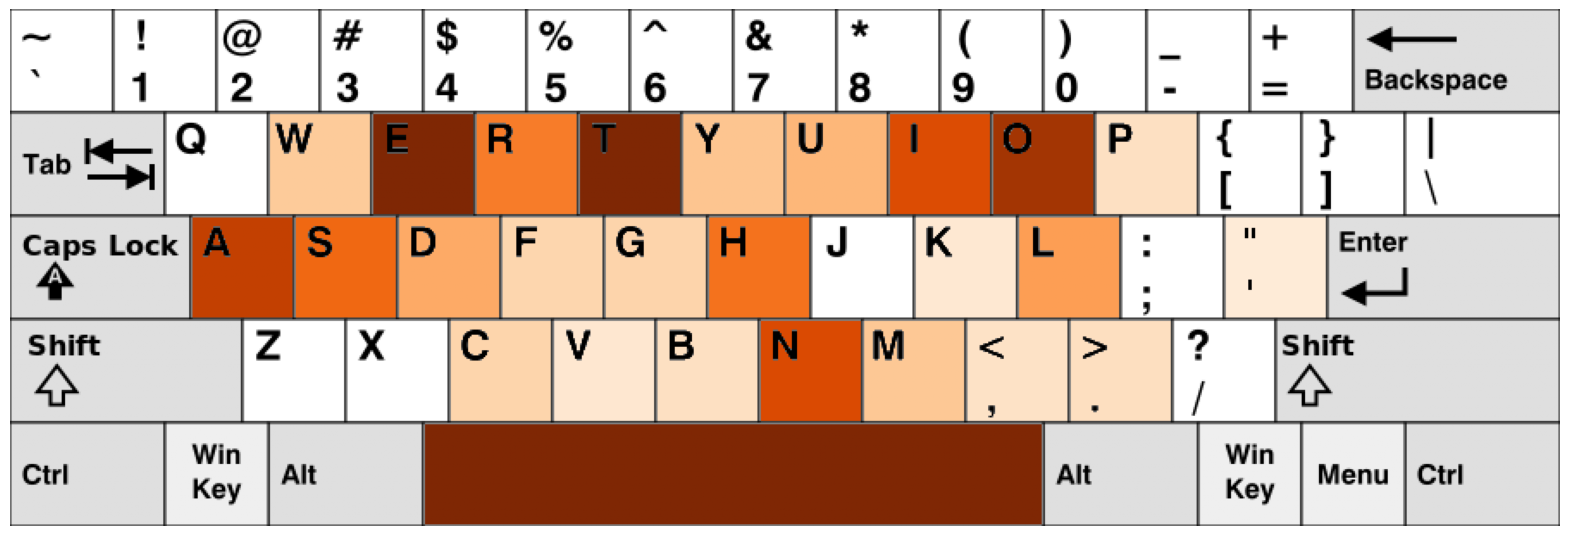

In [13]:
letter_occurances = df['letters'].agg(count_occurances)
letter_occurances = pd.DataFrame(letter_occurances.items(),columns=['chr','occ']).set_index('chr')
total = letter_occurances['occ'].sum()
def ext (chr_s,chr_us):
    lower_count = safe_get(letter_occurances,chr_us)
    upper_count = safe_get(letter_occurances,chr_s)
    return ((lower_count + upper_count)/total)
keyboard.show_heatmap(ext,colormap = 'Oranges',clip_f=keyboard.count_clip)

This should basically mimic the distribution of letters in english. 

Rates of mistyping a key:

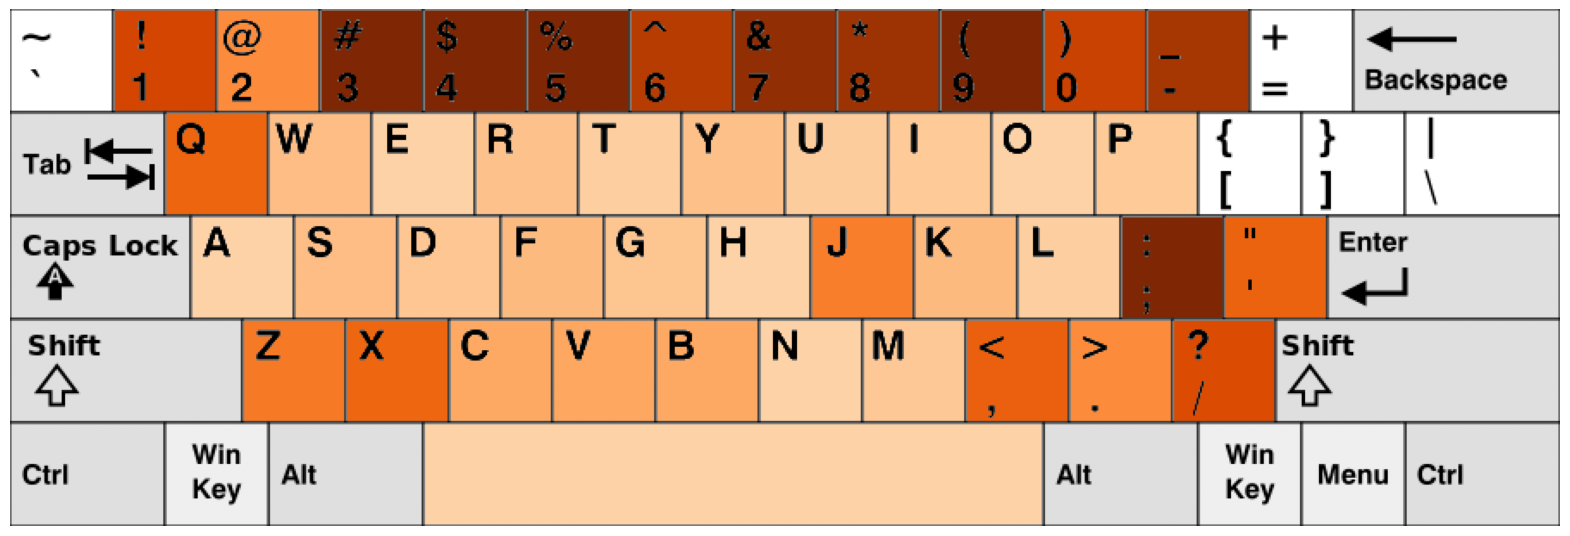

In [8]:
mistake_letters = df['mistake_letters'].agg(count_occurances)
mistake_letters = pd.DataFrame(mistake_letters.items(),columns=['chr','occ']).set_index('chr')


def ext_mistake_rates (chr_s,chr_us):
    lower_count = safe_get(letter_occurances,chr_us)
    upper_count = safe_get(letter_occurances,chr_s)
    total = upper_count + lower_count
    lower_mistakes= safe_get(mistake_letters,chr_us)
    upper_mistakes = safe_get(mistake_letters,chr_s)
    return (lower_mistakes + upper_mistakes)/total if total > 0 else 0
keyboard.show_heatmap(ext_mistake_rates,colormap = 'Oranges')


This visualisation seems to be supporting the hypothesis, that less frequent letters are more likely to get misstyped

Mistake latencies:

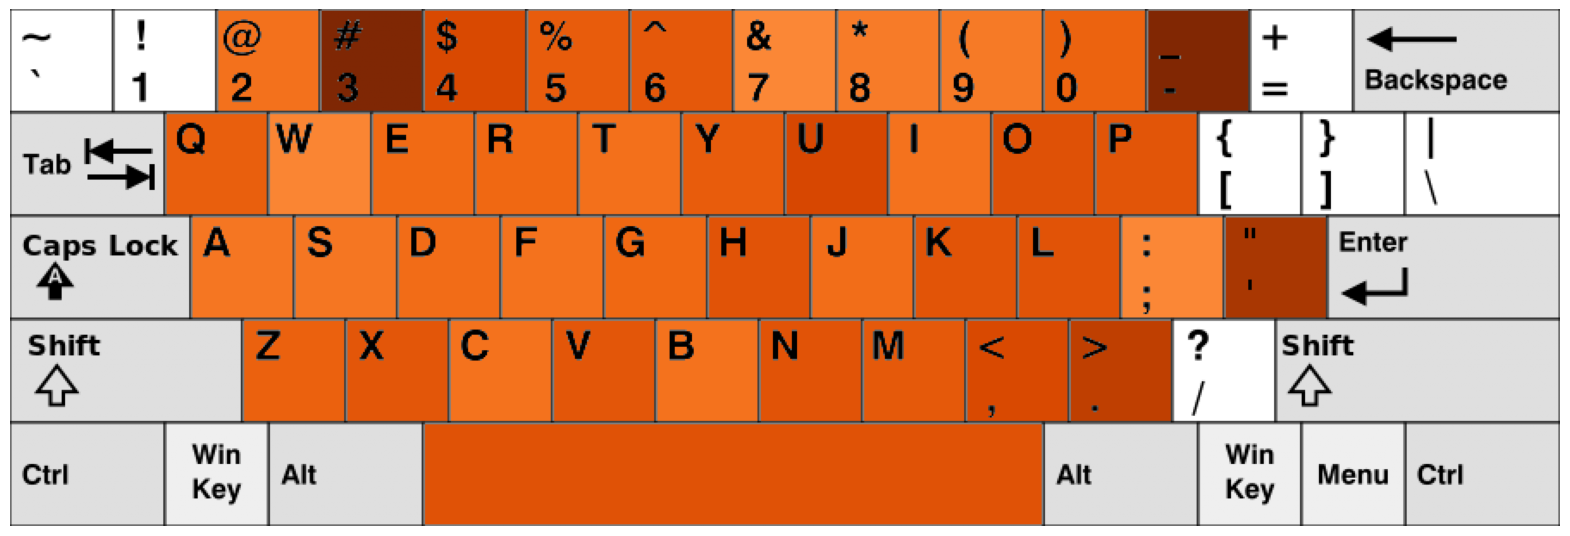

In [14]:
mistake_latencies = count_latencies(df['mistake_latencies'],df['mistake_letters'])
mistake_latencies = pd.DataFrame(mistake_latencies.items(),columns=['chr','lat']).set_index('chr')

avg_misake_lat = mistake_latencies['lat']/mistake_letters['occ']
max_lat = avg_misake_lat.max()

def ext_mistake_rates (chr_s,chr_us):
    lower_count = safe_get(mistake_letters,chr_us)
    upper_count = safe_get(mistake_letters,chr_s)
    total = upper_count + lower_count
    lower_lat= safe_get(mistake_latencies,chr_us)
    upper_lat = safe_get(mistake_letters,chr_s)
    return ((lower_lat + upper_lat)/total)/max_lat if total > 0 else 0
keyboard.show_heatmap(ext_mistake_rates,colormap = 'Oranges',clip_f=None)

Mistakes hurt similarly hard on all buttons. Probably because what takes time at a mistake is that the player continues typing for a while until realising he should stop. What then follows is a lot of deleting, which is also slow. 

Average latencies:

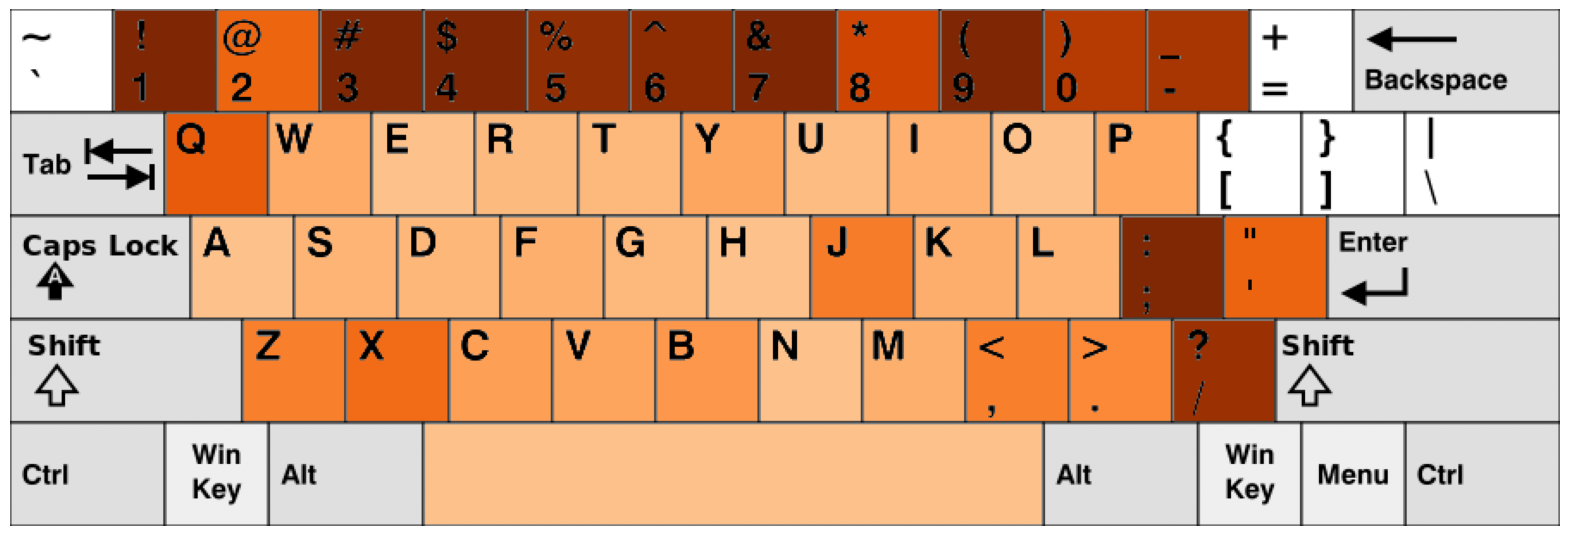

In [18]:

letter_latencies = count_latencies(df['latencies'],df['letters'])
letter_latencies = pd.DataFrame(letter_latencies.items(),columns=['chr','lat']).set_index('chr')
avg_letter_latencies = letter_latencies['lat']/letter_occurances['occ']

def ext (chr_s,chr_us):
    lower_lat = safe_get(letter_latencies,chr_us)
    lower_count = safe_get(letter_occurances,chr_us)
    upper_lat = safe_get(letter_latencies,chr_s)
    upper_count = safe_get(letter_occurances,chr_s)
    total_c = upper_count + lower_count
    return (lower_lat+upper_lat)/total_c if total_c > 0 else 0
keyboard.show_heatmap(ext,colormap = 'Oranges')


Less frequent letters have higher latencies. Visualisation looks pretty much identical with the one with mistake rates.

Average lowercase latencies:

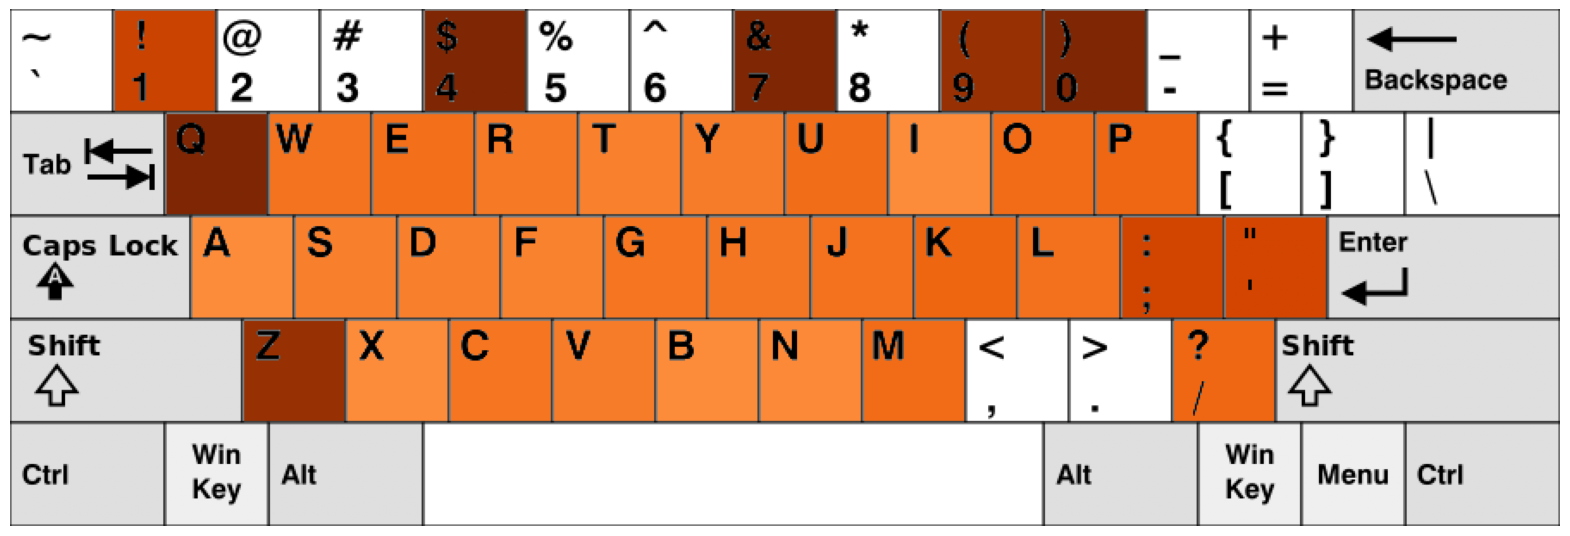

In [29]:

keypress_occurances = df.apply((lambda row: row['letters_all'][(row['operations']==parse_log.press_type.Add_correct) * (row['operations']==parse_log.press_type.Add_mistake)]), axis=1)
backspace_counts = df.apply(lambda row: np.sum((row['operations']==parse_log.press_type.Remove_correct) * (row['operations']==parse_log.press_type.Remove_mistake)), axis=1)


required_keypresses = df.apply(lambda row: len(row['letters']), axis=1)
total_keypresses = df.apply(lambda row: len(row['operations']), axis=1)
total_mistakes = df.apply(lambda row: np.sum(row['mistakes']), axis=1)

extra_keypresses_per_mistake = (total_keypresses - required_keypresses)/total_mistakes
extra_keypresses_per_mistake = extra_keypresses_per_mistake.fillna(0)
is_lowercase = letter_occurances.index.isin(keyboard.Row_infos.all_unshifted_combined)
lowercase_occ = letter_occurances[is_lowercase]
lowercase_latencies = letter_latencies[is_lowercase]

is_uppercase = letter_occurances.index.isin(keyboard.Row_infos.all_shifted_combined)
uppercase_occ = letter_occurances[is_uppercase]
uppercase_latencies = letter_latencies[is_uppercase]
avg_uppercase_latencies = avg_letter_latencies[is_uppercase]
avg_lowercase_latencies = avg_letter_latencies[is_lowercase]

avg_lowercase_latencies = pd.DataFrame(avg_lowercase_latencies)
avg_uppercase_latencies = pd.DataFrame(avg_uppercase_latencies)
avg_lowercase_latencies['key'] = lowercase_occ.index.map(lambda i:int(keyboard.Row_infos.all_unshifted_combined.index(i)))
avg_uppercase_latencies['key'] = uppercase_occ.index.map(lambda i:int(keyboard.Row_infos.all_shifted_combined.index(i)))

def ext (chr_s,chr_us):
    return avg_lowercase_latencies.loc[chr_us][0] if chr_us in avg_lowercase_latencies.index else 0
keyboard.show_heatmap(ext,colormap = 'Oranges')




Average uppercase latencies:

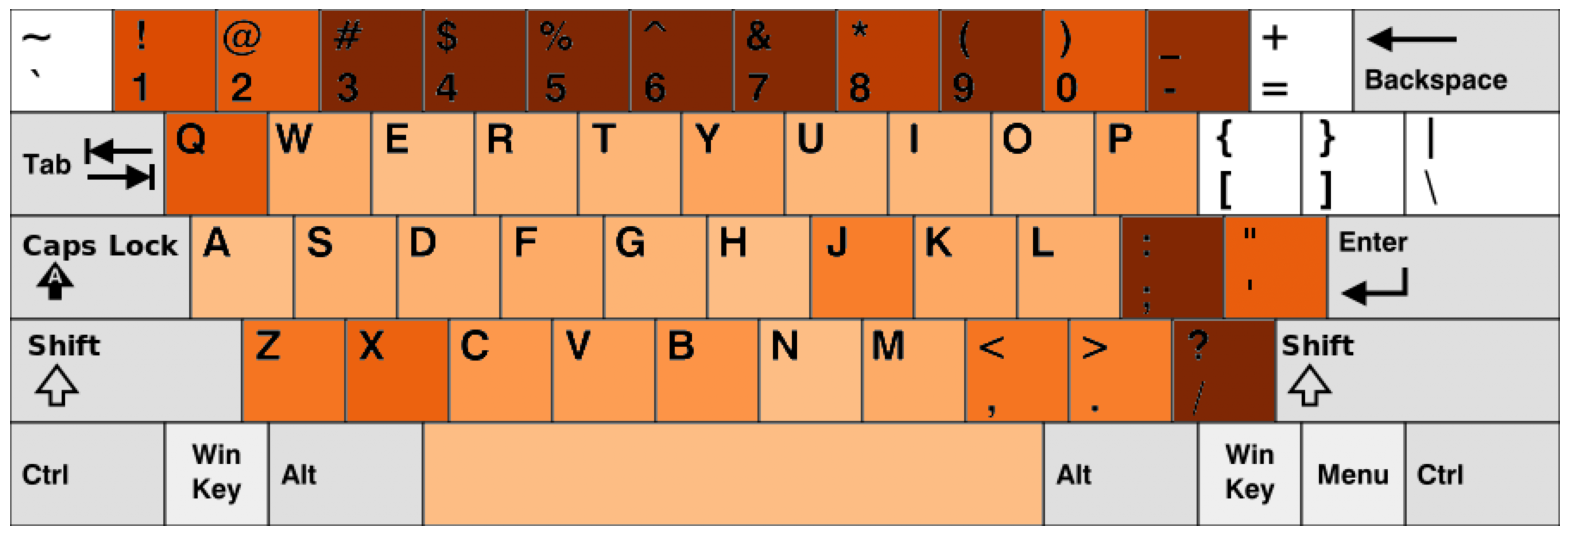

In [21]:

def ext (chr_s,chr_us):
    return avg_uppercase_latencies.loc[chr_s][0] if chr_s in avg_uppercase_latencies.index else 0
keyboard.show_heatmap(ext,colormap = 'Oranges')


Lattency difference between shifted and unshifted:

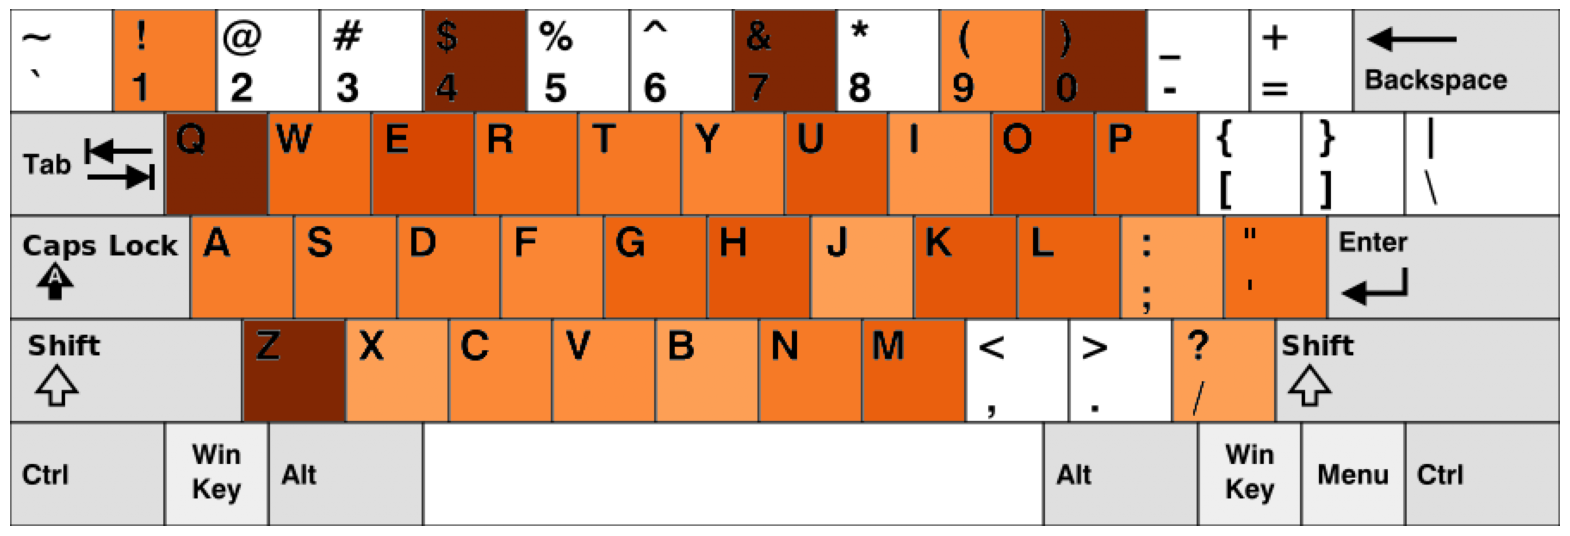

In [24]:
key_lat = avg_lowercase_latencies.merge(avg_uppercase_latencies,on='key',how='inner')
key_lat = key_lat.set_index('key')
key_lat = (key_lat['0_y']-key_lat['0_x'])
key_lat = pd.DataFrame(key_lat)
key_lat['letter'] = key_lat.index.map(lambda i:keyboard.Row_infos.all_unshifted_combined[i])
key_lat = key_lat.set_index('letter')

def ext (chr_s,chr_us):
    return key_lat.loc[chr_us][0] if chr_us in key_lat.index else 0
keyboard.show_heatmap(ext,colormap = 'Oranges')


## WPM and accuracy correlation

slope: 0.0828884382228181
intercept: 4.984835247978443e-16
r_value: 0.641695287487051
p_value: 0.0
std_err: 0.001071971605265329


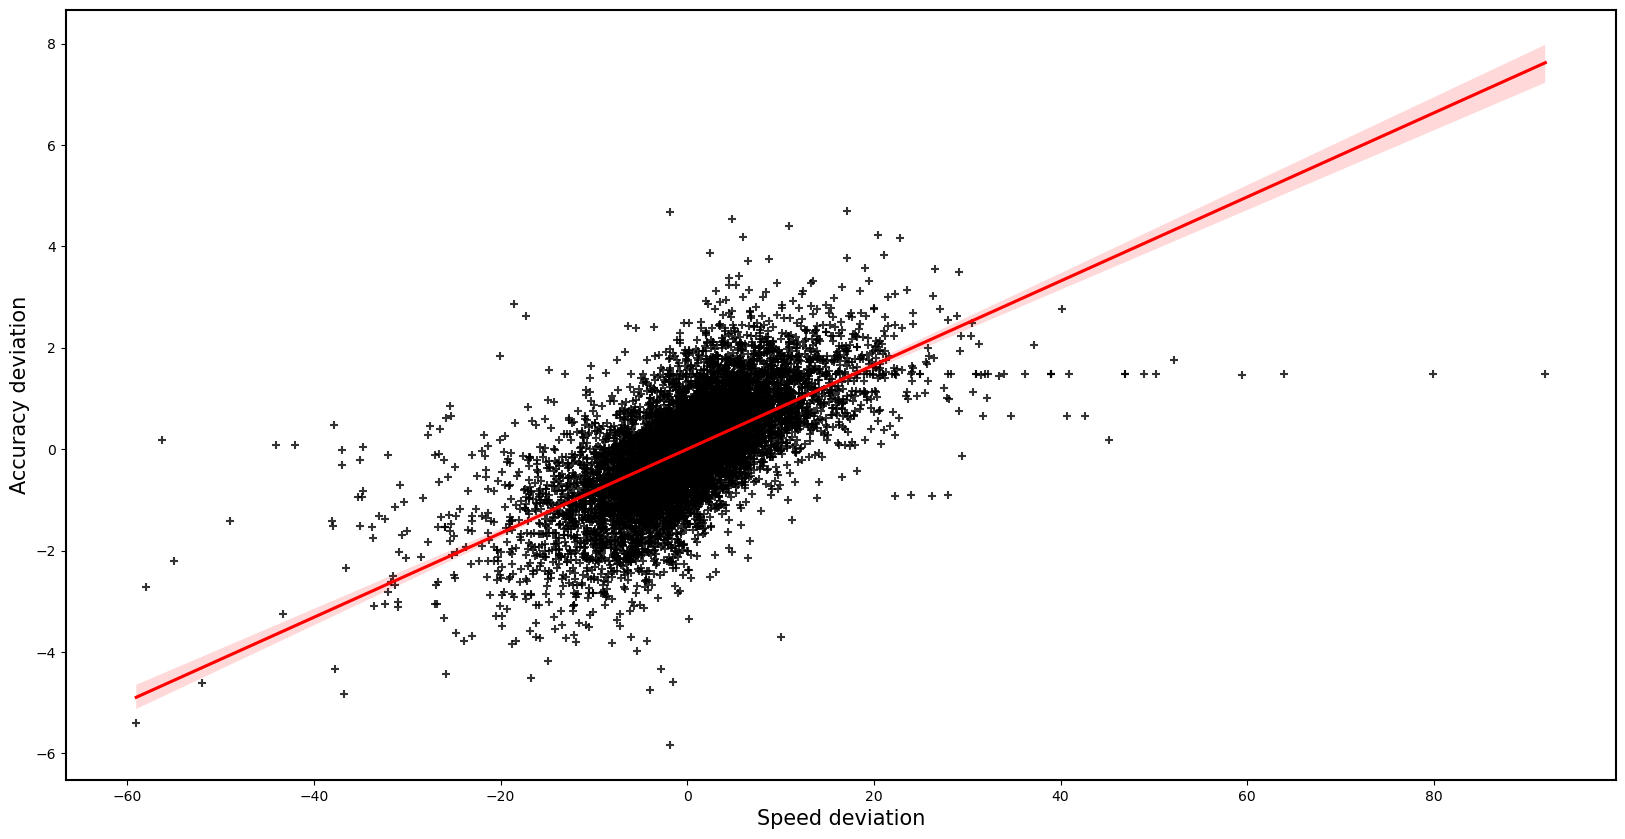

In [28]:
c = ['wpm','acc']
player_group = df.groupby('player')[c]
mn = df[c].sub(player_group.transform('mean'))
md = mn.add_suffix('_md')
#df[['player',"wpm", "acc"]].join(md)
#sb.relplot(md,x='wpm_md',y='acc_md')
ax = sb.regplot(md,x='wpm_md',y='acc_md',marker="+",
                    scatter_kws={"color": "black"}, line_kws={"color": "red"})
_ = ax.set(xlabel='WPM deviation', ylabel='Accuracy deviation')
import scipy.stats
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=md['wpm_md'],y=md['acc_md'])

print('slope:', slope)
print('intercept:', intercept)
print('r_value:', r_value)
print('p_value:', p_value)
print('std_err:', std_err)


Deviation of accuracy and deviation of wpm are strongly positively correlated

=> the less mistakes, the less time wasted repairing them

=> players should be mainly focusing on improving accuracy rather than  raw speed
